<a href="https://colab.research.google.com/gist/totorotoby/edca02a011a760d3ef36803c8468ec8f/kalman-filter-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I investage the possibility of applying the Kalman Filter to the SIR Model for infectious diease. The Kalman Filter is a method for combining solutions to mathematical models (specifically discrete dynamical systems) with real time oberservations and data about the current state of the system in question. For this reason an application of the Kalman Filter to an SIR Model for the Covid-19 pandemic could improve our predictive ability of the current state of the pandemic in real time.

In contrast to this method, a modeler could deside to formulate a purely statistical model to predict the future state of Covid-19, or the modeler could attempt to solve a purely mathmatical model. My interest in the Kalman Filter approach was intially two fold. First, in some cases (and definitely not always) a purely statstical model that acheives high accuracy, can become less interpretable and less reliant on domain science. Therefore I wanted incorporate a mathmatical model with interpretable parameters. On the other hand, especially in the Covid-19 case, we are collecting data in real time. This means we don't have data for estimating parameters to our SIR model prior to wanting to make predictions. This posses a sort of paradox. We want to make predictions in real time so we can implement different policies, but the parameters we rely on to make those predicitions must be determined by data that is currently being collected or has not been collected yet. The Kalman Filter gives a frame work for both error correcting and parameter estimation while data is being collected, which seems like a potential advantage.

In this project I would like to anwser three questions:

- Could the Kalman Filter be useful as a tool for predicting the state of Covid in real time?
- Is it important that are measurements of the infected covid population are very accurate?
- Can we achieve good estimates of the average rate of contacts per day in a population, by estimating parameters in the SIR model?

This notebook is organized in the following way. I give a brief statement of the SIR model, then an explanation of the Kalman Filter frame work. I air on the side of intuative explinations of the equations, but give a reference for proofs of their properties. Next I do 3 different implementations of the kalman filter. I first implement it on a linear system (un-related to SIR) on generated data to check my understanding, and for ease of implementation. I then implement a non-linear filter on the SIR model with generated data to set up a framework for thinking about it with real data. Lastly I implement a filter for predicting both state and model parameters on data of estimated number of infected people in different states around the US.

# Explanation of the SIR Model

The SIR Model is a system of ordinary differential equations that attempts to model an infectious disease moving through a population. The model splits the population into three seperate bins:
- $S(t)$ the fraction of the population that is susceptible to the diease at time $t$
- $I(t)$ the fraction of the population that is infected with the diease at time $t$
- $R(t)$ the fraction of the population that is recovered from the diease at time $t$

The model works by specifiying the transition rates between the bins in the following equations:

\begin{gather}
  \frac{dS}{dt} = -\beta IS\\
  \frac{dI}{dt} = \beta IS - \gamma I\\
  R = 1 - S - I
\end{gather}

Where $\beta$ is a rate of contacts per day parameter, and $\gamma$ is a rate of recovery per day parameter. A few things to note are: The the term in the first equation scales with both infected and susceptible people, which makes intuative sense because the more susceptible people there are the more possibly infected people there can be, and the more infected people there are the eaiser it is to contract the diease. Second, the negative terms in the first two equations signal a rate of leaving that bin, and the positive terms signal a rate of coming into that bin.

# Explanation of the Kalman Filter

The Kalman filter is a series of update rules for the mean and covariance matrix of the state variables in a system of interest, when measurements of the state variable are also present.

 Some of the variables in the equations are subscribed with the notation $a|b$. This notation stands for the variable on estimation step $a$, and measurement step $b$, where $a > b$. That is we are computing the $b$th timestep with $a$ prior measurements. I describe each of the equations separately. For full proofs of their optimality, and correctness see Gelb, 1974.

The variables within the equations are the following:

Variable  | Description 
-------------------|------------------
   $\hat{x}$   | The estimated mean value of the state variables
  $\Phi$       | The state-transition function (moves state forward in time according to the model)
  $P$ | The covariance matrix of the state variables
  $Q$ | The covariance matrix of the noise not captured by the model
  $K$ | The kalman gain matrix which is used to weight the measurement-prediction residual against the prediction
  $H$ | A restriction operator when measurements are not over all state variables
  $R$ | The covariance matrix for measurement errors
  $z$ | The measurements

The first of the 5 kalman filter equations is:

\begin{gather}
\hat{x}_{i|j} = \Phi_{i-1} \hat{x}_{i-1|j}\tag{1}\\
\end{gather}

This first equation is a simple application of a state-transtion function to a previously estimated state at time $i-1$, in which there is no measurement at time $i$ (I construct $\Phi$ in different ways in the following examples). The state transition function gives us our estimate of state in the next future timestep, or $n$ timesteps from now if we apply it $n$ times. When the underlying state-space model is linear this update is a matrix multiplication. If it non-linear it becomes a function evaluation. 

\begin{gather}
P_{i|j} = \Phi_{i-1} P_{i-1|j} \Phi_{i-1}^T + Q_{i}\tag{2}\\
\end{gather}

This equation updates the state covariance matrix from time $i-1$ to $i$ when there is no measurement present. Since $\Phi$ is a linear operator (on time in our case) the covariance matrix of a linear equation is given by the first term (for proof see for instance Searle, 1982). Since state-space models obviously do not model the system we are interested in perfectly, we can add another covariance matrix on, $Q$, reperesenting the variances not accounted for by the system. Estimating the values of $Q$ is a whole problem in itself as I discuss a bit later.

\begin{gather}
K_j = P_{i|j-1} H^T [H P_{i|j-1} H^T + R_j]^{-1}\tag{3}\\
\end{gather}

This equation computes the Kalman Gain matrix, used to merge measurement estimates with state-space predictions. The form of $K$ is the direct result of minimizing the sum of the variances in $P$ at each timestep. That is $K$ is the $K$ that solves $\frac{\partial\text{trace}(P_{i|j})}{\partial K_j} = 0$. To see intuatively what $K$ is doing, consider just a scalar system, with one state variable $x$. $\sigma^2_{i|j}$ denotes the variance of $x$ at time $i$ with $j$ measurements, and $\sigma_m$ denotes the variance associated with our measurements themselves, and where a direct mesurement of $x$ is present to that $H=1$. Then:

\begin{gather}
K_j = \frac{\sigma^2_{i|j-1}}{\sigma^2_{i|j-1} + \sigma^2_m}
\end{gather}

From this equation we see that $K$ is a metric of how confident we our in our measurements, and therefore how heavily we should weight it in our predictions. If $\sigma^2_{i|j-1}$ is large and $\sigma^2_m$ is small then we should weight our prediction closer to our measurements so $K_j$ is large. In the opposite scenerio ($\sigma^2_m$ is large) we should weight our state-space model more heavily and $K_j$ is small.

\begin{gather}
\hat{x}_{i|j} = \hat{x}_{i|j-1} + K_j[z_j - H\hat{x}_{i|j-1}]\tag{4}\\
P_{i|j} = [I - K_jH]P_{i|j-1}\tag{5}
\end{gather}

These two equations are used to merge the measurement observations with the state-space predictions. Its maybe easier to see what the first equation is doing when it is written as:

\begin{gather}
\hat{x}_{i|j} = [I - HK_j]\hat{x}_{i|j-1} + K_jz_j\\
\end{gather}

From the previous discussion we can see that when we are more confident in $z_j$ we weight it high, and we weight our prediction low, and the opposite goes for the opposite case.

The form of the second equation comes from a manipulation of $E[\hat{x}_{i|j}\hat{x}_{i|j}^T]$, i.e. the covariance matrix for our merged predictions. The full derivation is in Gelb.

# Digression on Kalman Filter on a Dampened Harmonic Oscillator

The SIR model is a non-linear dynamical system (as seen from the terms like $S\cdot I$). The above equations and explanations of the Kalman Filter only apply for propagating means and covariance matrices through time in a linear system. In order to implement a filter on the SIR model we will have to linearize it. For ease of implementation (and to get a flavor of the filter) I first tried a filter on a linear dynamical system: a damped harmonic oscilator. One example of a damped harmonic oscilator is the motion of a pendulum in either the $x$ or $y$ directions. The corresponding differential equation is derived from Force balance or newtons second law ($ma = F$):

\begin{gather}
m\frac{d^2x}{dt^2} + b\frac{dx}{dt} + k x = 0
\end{gather}

Where $x$ is the position of the pendulum in the $x$ direction and $m$ is the mass of the pendulum. The second derivative is acceleration. $b$ is a coefficent determining damping that is proptional to velocity, and $k$ is the spring constant, where the last term is Hooks Law. 

## State transition matrix

In order to track both displacement and velocity $v$, we can convert the above equation into first order form:

\begin{gather}
  \begin{bmatrix}
  x'\\
  v'\\
  \end{bmatrix}=
  \begin{bmatrix}
  0 & 1\\
  -\frac{k}{m} & -\frac{b}{m}\\
  \end{bmatrix}
  \begin{bmatrix}
  x\\
  v\\
  \end{bmatrix}
\end{gather}

In order to turn this into a discrete system we can take the crude approximation (eulers method):

\begin{gather}
  \frac{df}{dt}\approx\frac{f_{t + \Delta t} - f_t}{\Delta t}
\end{gather}

 The discrete approximate is then:

\begin{align}
\begin{bmatrix}
  x\\
  v\\
\end{bmatrix}_{t + \Delta t} = 
\Phi \begin{bmatrix} x\\ v\\ \end{bmatrix}_t && 
\Phi =
\begin{bmatrix}
1 & \Delta t \\
 -\frac{k\Delta t}{m} & -\frac{b\Delta t}{m} + 1
\end{bmatrix}
\end{align}

So for our problem $\Phi$ is the state-transition matrix. 

As a side note for more accuracy in the state-transition matrix one can trucate the matrix exponential at higher terms (corresponding to different Runga-kutta methods). I gave this a try in the below code and the difference was negliable.

## Noise Covariance matrix

We also need the covariance matrix $Q$ for the noise within the system. There isn't any way of determining this matrix exactly apriori that I know of, but I generated one by doing the following:

We can assume that at some timestep $t_0$ the velocity of our pendulum is perturbed with a variance $\sigma^2_{vp}$ with corresponding covariance matrix:
\begin{gather}
\begin{bmatrix}
0 & 0\\
0 & \sigma^2_{vp}\\
\end{bmatrix}
\end{gather}

We would like to know how variances and covariances of velocity and displacement from some unknown perturbation effect the variances and covariances at the next timestep. i.e. this is exactly what the $Q$ matrix is. Now since $\Phi$ is a linear transformation that moves us one step forward in time, we just need to propagate the above matrix through the system defined by $\Phi$ .The covariance matrix under a linear transformation such as $\Phi$ gives that:

\begin{gather}
Q \approx \Phi \begin{bmatrix}
0 & 0\\
0 & \sigma^2_v\\
\end{bmatrix} \Phi^T
= 
\begin{bmatrix}
  \sigma^2_v \Delta t ^2 & (-\frac{b \Delta t}{m} + 1)(\sigma^2_v \Delta t)\\
  (-\frac{b \Delta t}{m} + 1)(\sigma^2_v \Delta t) &  \sigma^2_v (-\frac{b \Delta t}{m} + 1)^2\\
\end{bmatrix}
\end{gather}

## Measurement Covariance Matrix and Intial Conditions

Since this is a purely fictious example with generated data, I decided to just use a diagonal matrix for $R$. For it to be anything else I would need to know about how the measurements were taken. So:

\begin{gather}
  R = \begin{bmatrix}
  \sigma^2_{xm} & 0\\
  0 & \sigma^2_{vm}\\
  \end{bmatrix}
\end{gather}

For our inital means in the code we can just set them to whatever intial condition we want our system to be, and for initial state covariance matrix we can experiment to see what initial guesses cause our predictions to look like, but it probably makes sense to start with high variances as we wouldn't want to be to confident with our guess.

## Data Generation

There are a few considerations to take when generating the data to test the filter on. First when we generate ground truth data we can do it in a combination of different ways

  - Use a continious solution and perturb those values by sampling from $Q$ or by a different covariance matrix 
  - Timesteping with a discrete approximation and perturbing solutions by either of the above options
  - In most systems the noise is not completely white. That is it is probably corralated in time. If we perturb using $Q$ we cannot capture this, and this may lead to low performance from the kalman filter, because the state model alone will return the mean of a system perturbed using $Q$, which is infact a good estimate.

Under the assumption that the continious equations model dampened harmonic oscillators extremely well (i.e. it explains away a large portion uncertainty) then using a closed from solution to generate ground truth probably makes more sense (sometimes this won't be the case since a closed from solution isn't available). This is because our discrete system is only a first order approximation in $\Delta t$ of the continious solution, and I have no idea how the error in the euler method may be correlated with the states in the system.


Lastly we make the assumption that we can measure both displacement and velocity so that $H$ is the identity. Later when doing the SIR model this won't be the case.


In [ ]:
#@title

install.packages("mvtnorm")
library("mvtnorm") 
install.packages("abind")
library("abind") 
install.packages("expm")
library(expm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘expm’


The following object is masked from ‘package:Matrix’:

    expm




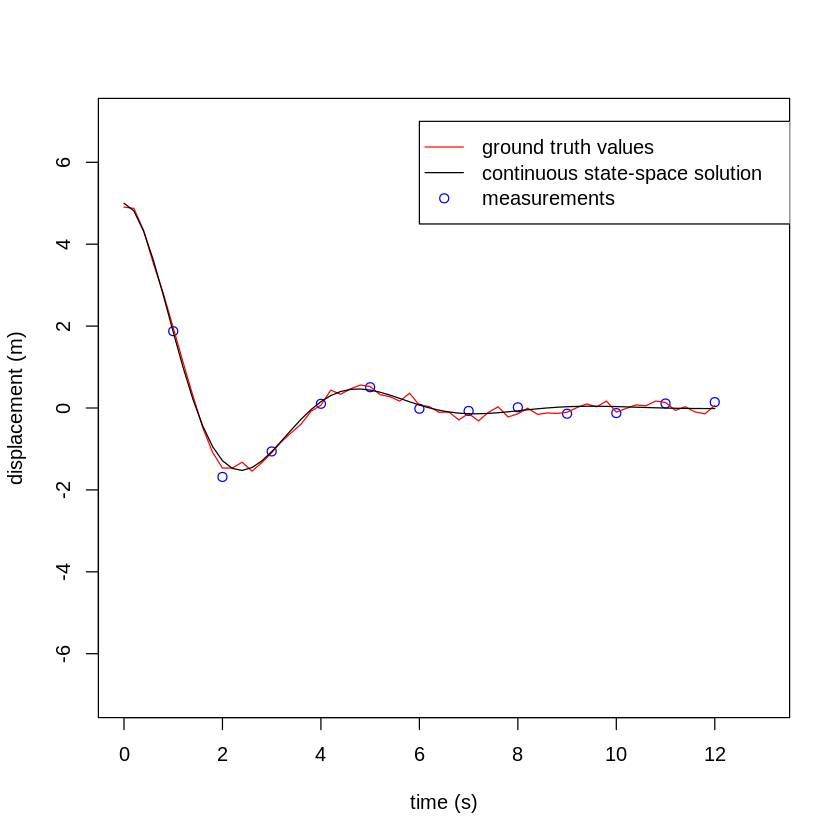

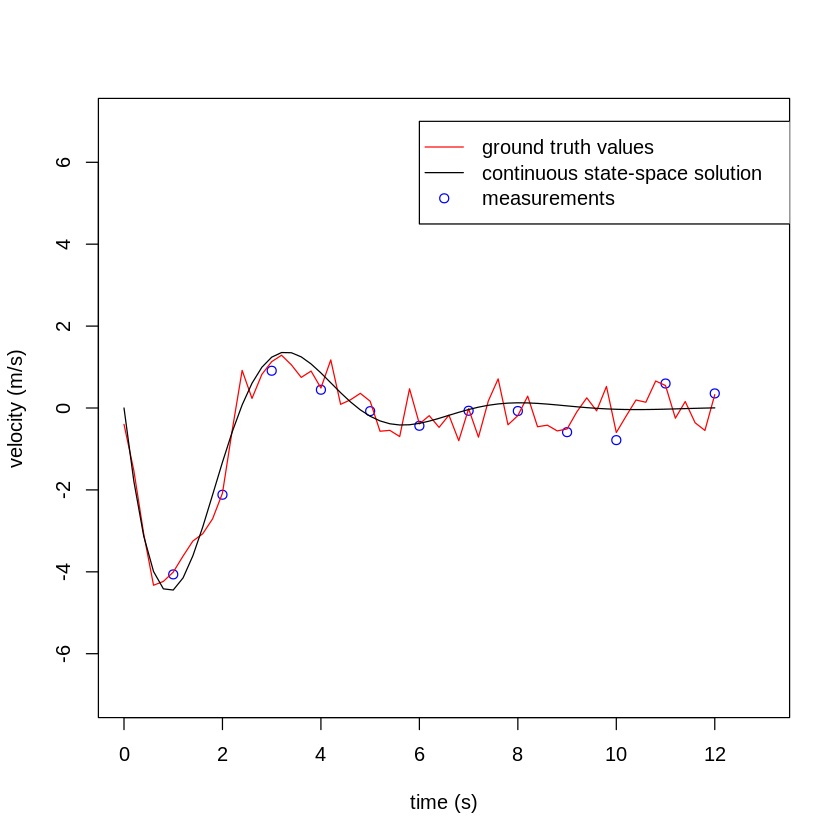

In [ ]:
#@title

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# TIME PARTITIONING
# Total time (seconds)
T = 12
# Total number of measurements
Nm = 12
# Number of timesteps between measurements
npm = 5
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (seconds)
dt = T/N
# length of measurement step (seconds)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# physical parameters and state equation solutions
# mass of pedulum (kg)
m = 1
# air resistance constant
b = 1
# spring constant
k = 2

# functions for continious solution for (k=2, b=1 ,m=1)
x_sol <- function(t, x0, v0)
{
  x = 2 * v0 * exp(-t/2)*sin(sqrt(7)*t/2)/sqrt(7) + 1/7*x0*exp(-t/2)*(7*cos(sqrt(7)*t/2) + sqrt(7)*sin(sqrt(7)*t/2))
  return(x)
}
v_sol <- function(t, x0, v0)
{
v = - (4 * x0 *exp(-t/2) * sin(sqrt(7)*t/2))/sqrt(7) + 1/7 * v0 * exp(-t/2) * (7*cos(sqrt(7)*t/2) - sqrt(7)*sin(sqrt(7)*t/2))
return(v)
}
# system of equations
A = array(c(0 , -k/m, 1, -b/m), dim=c(2,2))
# identity matrix
I = array(c(1,0,0,1), dim=c(2,2))
# discrete system state equation matrix (Rk something)
F = I + A*dt + ((A*dt)%^%2)/4 + ((A*dt)%^%3)/6
FT = aperm(F)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# generate measurements
# velocity perterbation variance matrix
VP_sigma = array(c(0,0,0,.3), dim=c(2,2))
# variance in displacement measurements
xm_var = .01
# variance in velocity measurements
vm_var = .01
# estimate of Q matrix
Q = F%*%VP_sigma%*%FT
# White noise samples
w = rmvnorm(n=Np, mean=c(0,0), sigma=Q)
# Measurement covariance matrix
R = array(c(xm_var, 0, 0, vm_var), dim=c(2,2))
# measurement noise samples
r = rmvnorm(n=Nm, mean=c(0,0), sigma=R)
# ground truth values
g = array(dim=c(Np,2))
# measurement values
z = array(dim=c(Nm,2))

ind = 1
m_ind = 1
for (t in time){
  g[ind,1] = w[ind, 1] + x_sol(t, 5, 0)
  g[ind,2] = w[ind, 2] + v_sol(t, 5, 0)
  if (mtime[m_ind] == t){
    z[m_ind, ] = g[ind, ] + r[m_ind, ]
    m_ind = m_ind + 1
  }
  ind = ind + 1
}

xlims = c(0,T+1)
ylims = c(-7,7)
plot(mtime, z[,1], xlim=xlims, ylim=ylims, col="blue", xlab="time (s)", ylab="displacement (m)")
lines(time, g[,1], xlim=xlims, ylim=ylims, type="l", col="red", xlab="time (s)", ylab="displacement (m)")
lines(time, x_sol(time, 5, 0), type="l", xlim=xlims, ylim=ylims,xlab="time (s)", ylab="displacement (m)")
legend(6, 7, legend=c("ground truth values", "continuous state-space solution", "measurements"),
       col=c("red", "black", "blue"), lty= c(1,1,NA), pch=c(NA,NA,1))

plot(mtime, z[,2], xlim=xlims, ylim=ylims, col="blue", xlab="time (s)", ylab="velocity (m/s)")
lines(time, g[,2], xlim=xlims, ylim=ylims, type="l", col="red")
lines(time, v_sol(time, 5, 0), type="l", xlim=xlims, ylim=ylims)
legend(6, 7, legend=c("ground truth values", "continuous state-space solution", "measurements"),
       col=c("red", "black", "blue"), lty= c(1,1,NA), pch=c(NA,NA,1))



## Covariance Propagation Check

The above two plots show generated ground truth values, measurements , and the continious solution to the differential equation modeling the motion.

Before we try to simulate integrating measurements as we time step along (run the Kalman Filter), as a sanity check we can look at the error bars for the covariance propagation around the computed mean without any measurements integrated. 

We exepect the variances of all variables to shrink in time for the following reason. We know that our differential equation is stable. Where stability means that as $t\rightarrow\infty$, solutions with similar initial conditions stay in the same neighborhood as eachother. This is because the damping of the oscillation regardless of the our initial conditions forces us towards static equalibrium at 0. With this in mind we should become more confident as time goes on that our solution is $x(t\rightarrow\infty) = 0$, i.e. are variances shrink, untill all that is left is the variances from $Q$. The same would not be true for expontial growth for instance, because the smallest error in intial measurement with have greater effects as we move forward in time. The two below plots display that this is true.

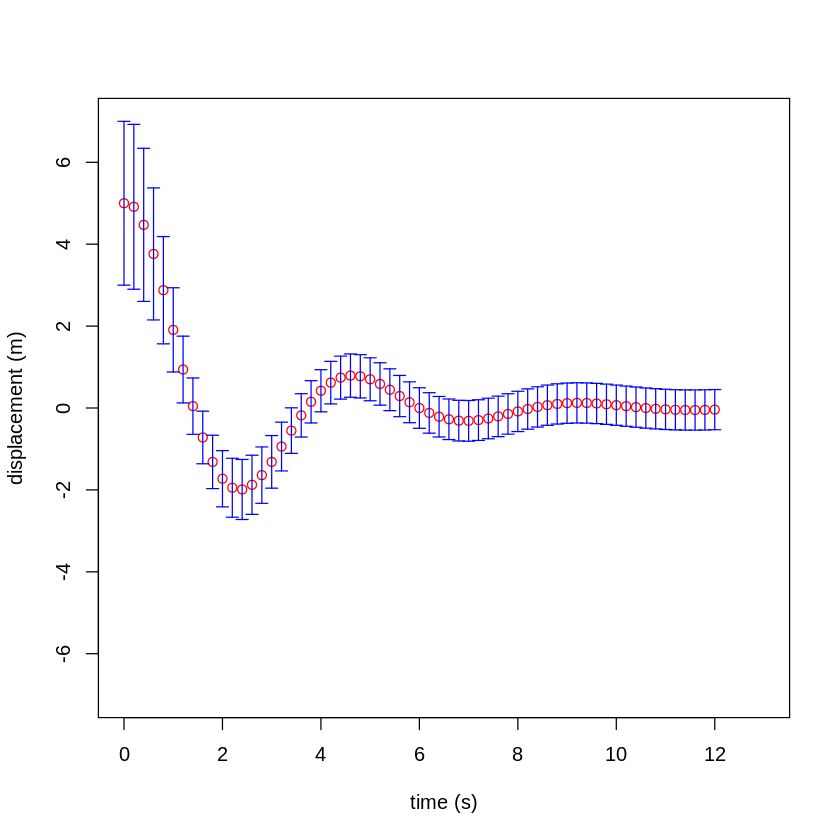

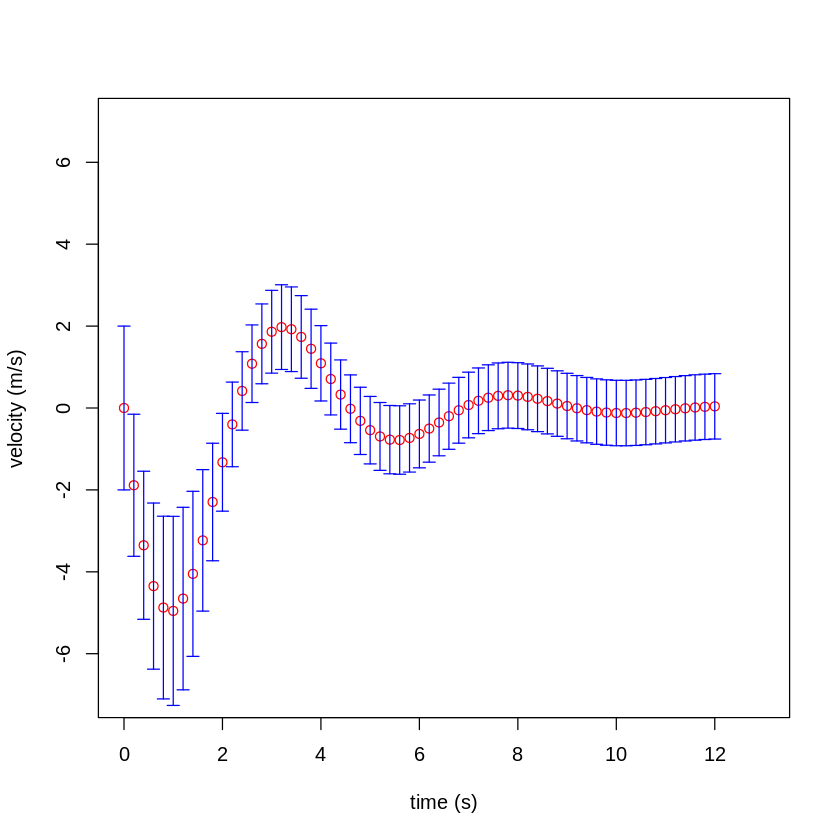

In [ ]:
#@title

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting means and stds without merging measurements

# mean vector
Xhat = array(c(5,0), dim=c(Np, 2))
# covariance vector
P = array(c(2, 0,0,2), dim = c(Np, 2, 2))

for (i in 2:Np)
{
  Xhat[i, ] = F%*%Xhat[i-1, ]
  P[i, , ] = F%*%P[i-1, , ]%*%FT + Q
}

bottom = Xhat[, 1] - P[ ,1 ,1]
top = Xhat[,1] + P[, 1, 1]
plot(time, Xhat[ ,1], xlim = xlims, ylim=ylims, col="red", xlab="time (s)", ylab="displacement (m)")
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="blue")

bottom = Xhat[, 2] - P[ ,2 ,2]
top = Xhat[,2] + P[, 2, 2]
plot(time, Xhat[ ,2], xlim = xlims, ylim=ylims, col="red", xlab="time (s)", ylab="velocity (m/s)")
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="blue")

## Kalman Filter for Damped Oscillator

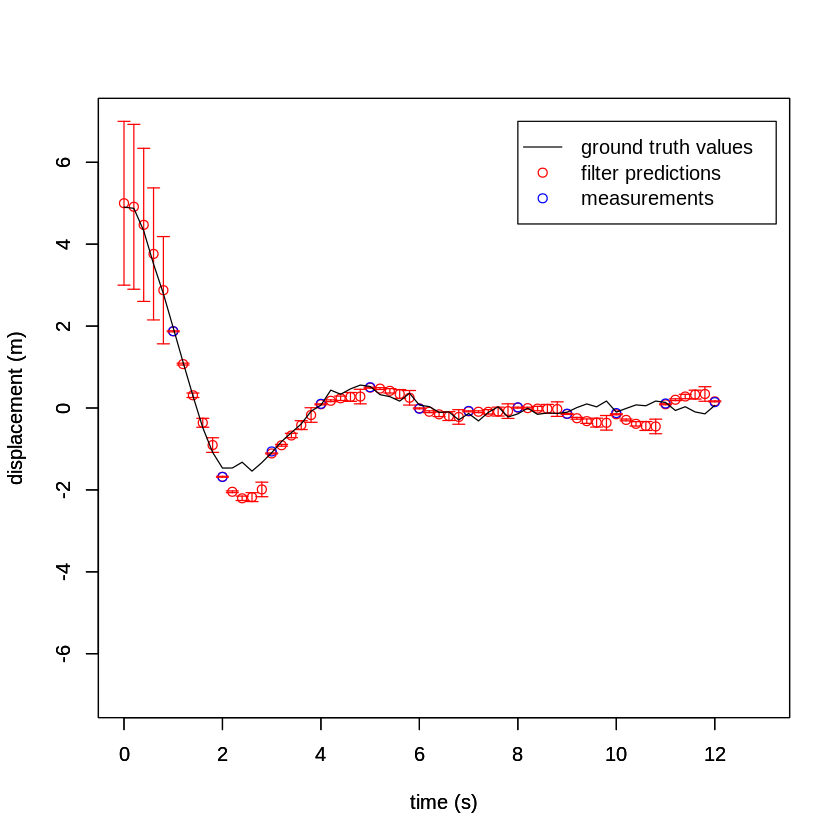

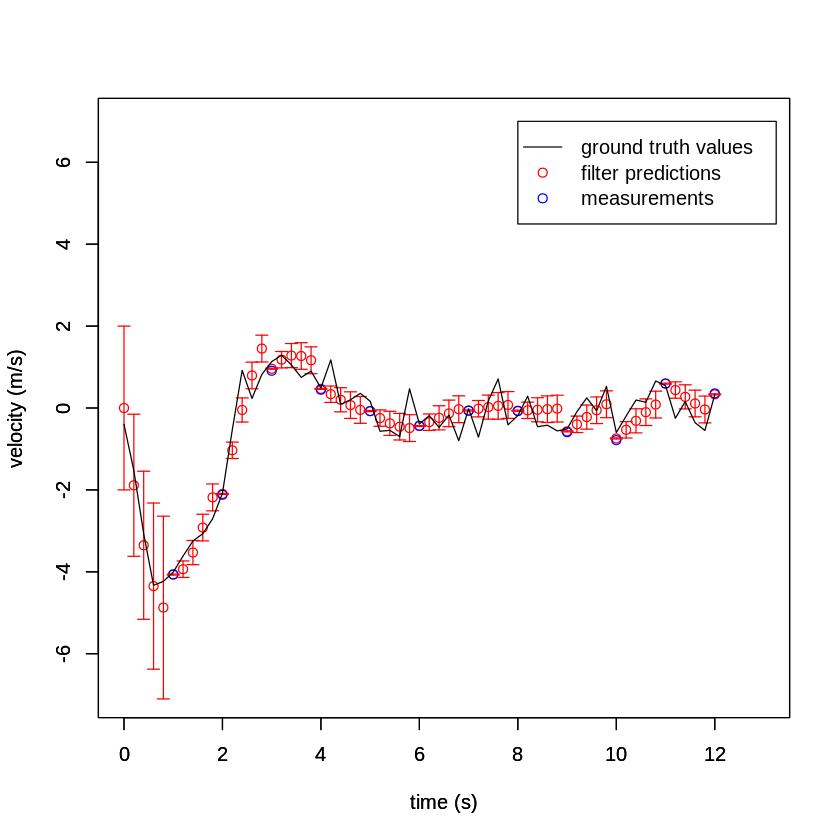

In [ ]:
#@title

# mean vector
Xhat = array(c(5,0), dim=c(Np, 2))
#
Xhat_no_m = array(c(5,0), dim=c(Np, 2))
# covariance vector
P = array(c(2, 0,0,2), dim = c(Np, 2, 2))
# measurement restriction operator
H = array(c(1,0,0,1), dim = c(2,2))
HT = aperm(H)
# Kalman Gain matrices
K = array(dim= c(Nm, 2,2))
m_ind = 1
for (i in 2:Np)
{
  # estimate
  Xhat[i, ] = F%*%Xhat[i-1, ]
  Xhat_no_m[i, ] = F%*%Xhat_no_m[i-1, ]
  P[i, , ] = F%*%P[i-1, , ]%*%FT + Q

  if (mtime[m_ind] == time[i]){
    # measurement merging
    K[m_ind, , ] = P[i, , ] %*% HT %*% solve(H %*% P[i, , ] %*% HT + R)
    Xhat[i,] = Xhat[i,] + K[m_ind, ,] %*% (z[m_ind, ] - H %*% Xhat[i,])
    P[i, , ] = (I - K[m_ind, , ]%*%H)*P[i, , ]
    m_ind = m_ind + 1
  }
}

bottom = Xhat[, 1] - P[ ,1 ,1]
top = Xhat[,1] + P[, 1, 1]
plot(time, Xhat[, 1], col="red", xlim=xlims, ylim=ylims, , xlab="time (s)", ylab="displacement (m)")
par(new=TRUE)
plot(mtime, z[,1], col="blue", xlim=xlims, ylim=ylims, xlab="time (s)", ylab="displacement (m)")
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="red")
lines(time, g[, 1], type="l", xlim=xlims, ylim=ylims)
legend(8, 7, legend=c("ground truth values", "filter predictions", "measurements"),
       col=c("black", "red", "blue"), lty= c(1,NA,NA), pch=c(NA,1,1))

bottom = Xhat[, 2] - P[ ,2 ,2]
top = Xhat[, 2] + P[, 2, 2]
plot(time, Xhat[, 2], col="red", xlim=xlims, ylim=ylims, xlab="time (s)", ylab="velocity (m/s)")
par(new=TRUE)
plot(mtime, z[, 2], col="blue", xlim=xlims, ylim=ylims, xlab="time (s)", ylab="velocity (m/s)")
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="red")
lines(time, g[, 2], type="l", xlim=xlims, ylim=ylims)
legend(8, 7, legend=c("ground truth values", "filter predictions", "measurements"),
       col=c("black", "red", "blue"), lty= c(1,NA,NA), pch=c(NA,1,1))

## Error Anaylsis

As a quick error analysis, I compute an $\mathcal{l}^2$ error over every timestep with the pure state-space simulation, and the kalman filter system to compare.

\begin{gather}
  error = \frac{\sum_{i=0}^{Np} (\hat{x}_i - g_i)^T(\hat{x}_i - g_i)}{Np}
\end{gather}

Where $g_i$ is the generated "ground truth" at timestep $i$, and $Np$ is the total number of timesteps.


In [ ]:
#@title

error_kalman = 0
error_state_sys = 0

for (i in 1:Np)
{
  error_kalman = error_kalman + ((Xhat[i, ] - g[i, ])%*%(Xhat[i, ] - g[i, ]))[1]
  error_state_sys = error_state_sys + ((Xhat_no_m[i, ] - g[i, ])%*%(Xhat_no_m[i, ] - g[i, ]))[1]
}

cat("Filter error: ", error_kalman/Np, "\n")
cat("State space only error: ", error_state_sys/Np)

Filter error:  0.2510377 
State space only error:  0.3434795

# Extended Kalman Filter for the SIR model with Generated Data

In the next section it is useful to refer to the SI part of the system as:

\begin{gather}
  F(S,I,R) = \begin{bmatrix}
          -\beta IS\\
          \beta IS - \gamma I\\
          \end{bmatrix}
\end{gather}

and each component as $F_S$, and $F_I$.

Now that we have a linear filter, we can attempt a filter on the non-linear SIR system. The main issue with the previously defined filter equations is that the covariance propagation equation doesn't work for a non-linear verision of $\Phi$. This can be addressed by linearizing the discrete state transition equation.

First, to derive the discrete transition equation we can apply euler to the continious system of equations which yields:
\begin{gather}
\Phi(S_{t-1}, I_{t-1}) = 
\begin{bmatrix}
  S\\
  I\\
\end{bmatrix}_t
=\begin{bmatrix}
\Delta t F_s + S_{t-1}\\
\Delta t F_I + I_{t-1}\\
\end{bmatrix}
\end{gather}

The easiest way around the covariance propgation problem is to linearize $\Phi$ by taking its taylor expansion and ignoring the third term onwards.
The taylor expansion of $\Phi(x)$  around $a$ is:
\begin{gather}
  \Phi(x) = \Phi(a) + J^\Phi(a)(x-a) + \frac{1}{2}(x-a)^TH^\Phi(x-a) \cdots\\
\end{gather}
Where $J^\Phi$ and $H^\Phi$ are the Jacobian and Hessian, and $x$ and $a$ are vectors of $I,S$ and $R$, values. Since we are attempting to linearize $\Phi(x)$ we drop all of the terms after the second one so that:
\begin{gather}
  \phi(x) = \Phi(a) + 
  \begin{bmatrix}
  -\Delta t\beta I + 1 & - \Delta t \beta S\\
  \Delta t\beta I & \Delta t(\beta S - \gamma) + 1\\
  \end{bmatrix}
  (x - a)
\end{gather}

Our new scheme is then to update our state mean using $\Phi$, and the state-covariance using $J_\Phi$. That is the first and second filter equations are now:

\begin{gather}
  \hat{X}_{i|j} = \Phi(\hat{X}_{i-1|j})\\
  P_{i,j} = J^\Phi_{i-1} P_{i-1,j} [J^\Phi_{i-1}]^T\\
\end{gather}

So far we have only delt with $\hat{S}$ and $\hat{I}$. To compute $\hat{R}$ at any time $t$, I just use: 

$$\hat{R} = 1 - \hat{S} - \hat{I}$$

and to compute the variance of $\hat{R}$ at any time we can use:

$$\sigma^2_R = \sigma^2_S + \sigma^2_I + 2Cov(I,R)$$

All these quatities are avaliable assuming we first do the $\hat{S}$ and $\hat{I}$ computations.


## Ad-Hoc construction of $Q$ and $R$

The construction of $Q$ and $R$ are both, in my case, Ad-Hoc. I would have to do research into error anaylsis of the SIR model against real world pandemics to construct a more informed $Q$. A little bit more can be said about $R$, but statistics about false positives and negatives would need to be used.

To construct $Q$, I use the same trick I did with the linear system above, but make the assumption of a perterbation in $I$ with variance $\sigma_{Ip}^2$ at a single time.

For the $R$ matrix we can note that if we miss count the infected population we necessarly miss count the suspetiable population the opposite direction, so our $R$ matrix will have negative covariances. We also make the assumption that the false-positives approximately balance out false-negatives so that the variances are approximately the same.

We can first look at what happens when propagating state and covariance without merging any measurements.



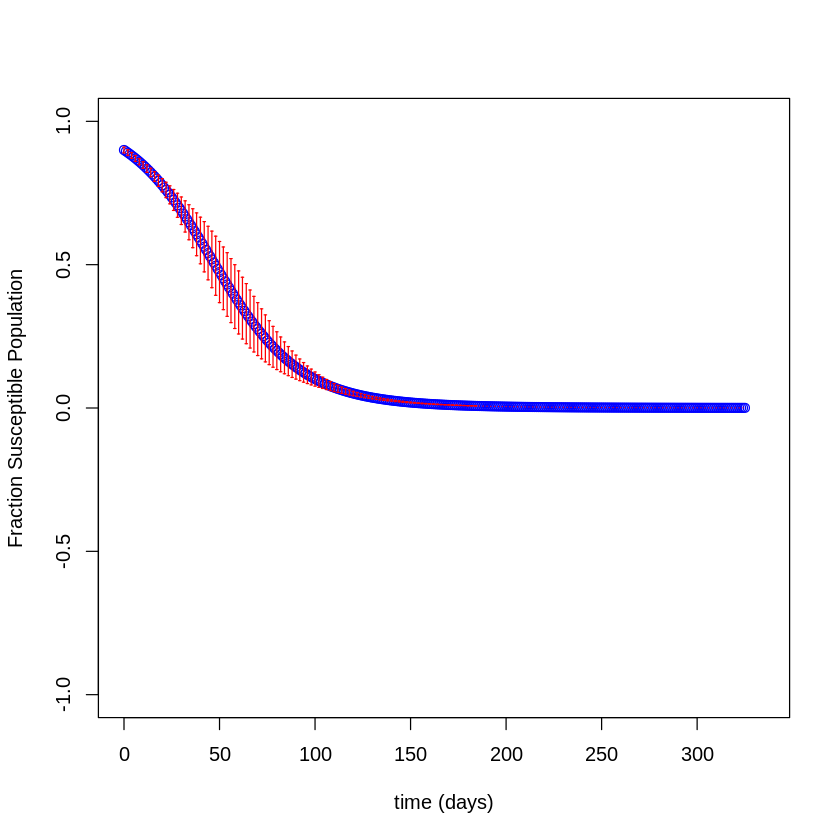

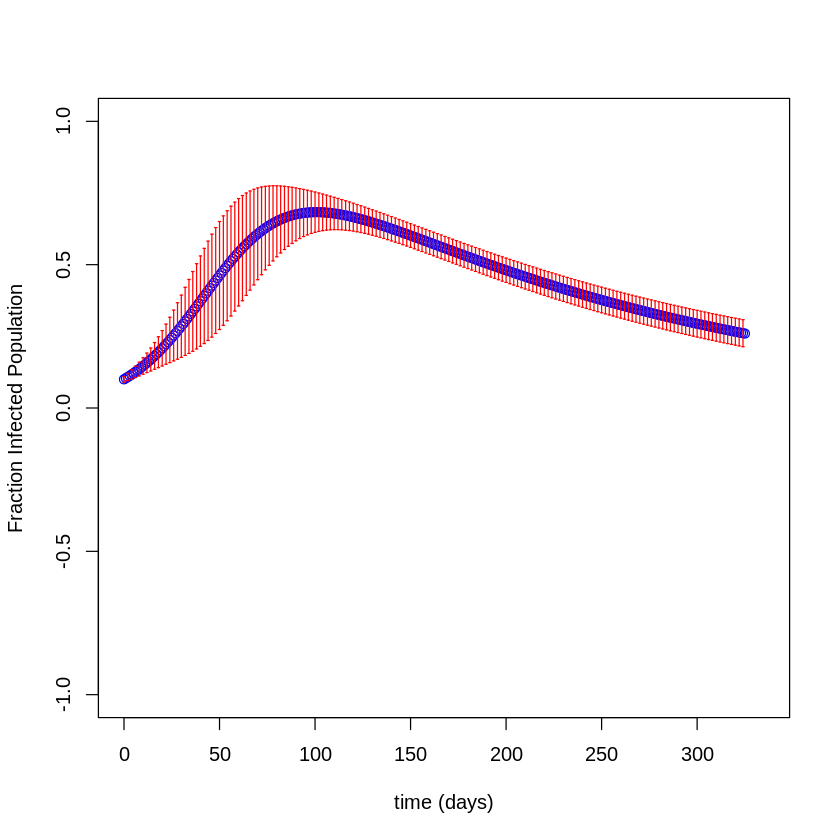

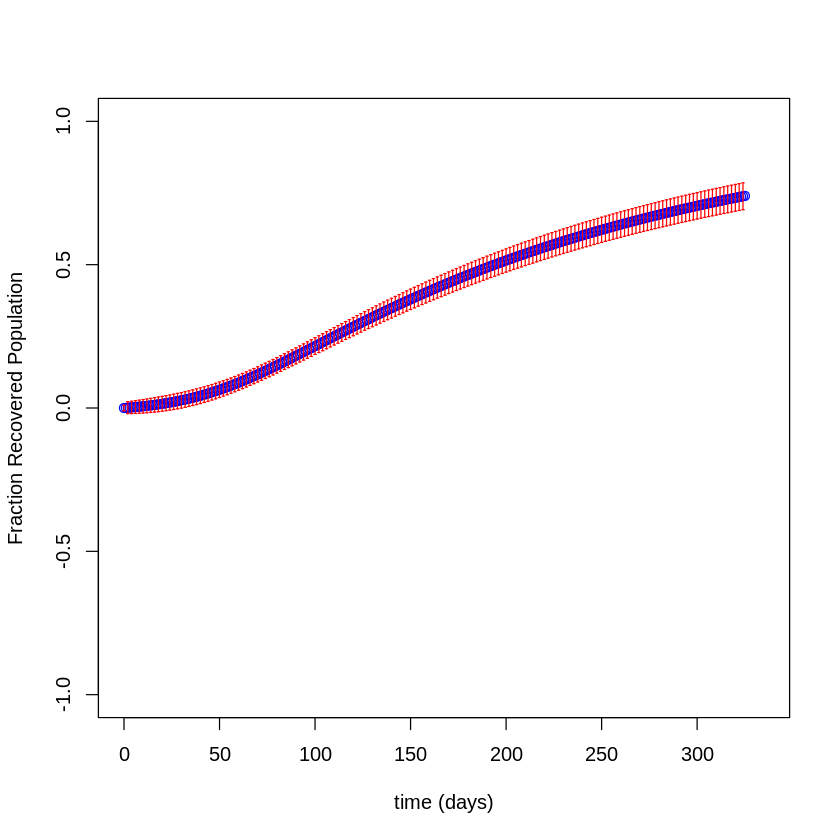

In [ ]:
#@title

options(warn=-1)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# time partitioning
# Total time (days)
T = 325
# Total number of measurements
Nm = T/5
# Number of timesteps between measurements
npm = 5
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (Days)
dt = T/N
# length of measurement step (Days)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# physical parameters and state equation solutions
# rate of contacts (1/)
beta = .05
# rate of recovery
gamma = .005
# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2],beta*state[1]*state[2] - gamma*state[2]))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(- dt * beta * state[2] + 1, dt*beta*state[2],
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1), dim=c(2,2)))
}


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data, state, and covariance initialization 
# ground truth vector to be filled
g = array(dim=c(Np,3))
# measurement vector to be filled
z = array(dim=c(Nm,3))
# state vectors
state = array(dim=c(Np,3))
# intial state
state[1,] = c(.9,.1,0.0)
# covariance matricies  
P = array(dim=c(Np,3,3))
# inital covariance
P[1, ,] = array(c(.01, 0, 0, 0, .01, 0, 0 ,0, .01), dim=c(3,3))
# infected perterbation
I_pert = .0005
# perterbation matrix
I_pertM = array(c(0,0,0, I_pert), dim=c(2,2))
# measurement error in suseptiable
merr_s = .0001
# measurment error in infected
merr_i = .0001
# measurement covariance matrix
R = array(c(merr_s, -.99*(sqrt(merr_s))*(sqrt(merr_i)), -.99*(sqrt(merr_s))*(sqrt(merr_i)), merr_i), dim=c(2,2))
r = rmvnorm(n=Nm, mean=c(0,0), sigma=R)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# simulation loop
#measurement index
m_ind = 1 
maxt = 0
for (i in 2:Np)
{
  # update state for plotting
  state[i,1:2] = Phi(state[i-1, 1:2], beta, gamma, dt)
  # update recovered
  state[i,3] = 1 - state[i,1] - state[i,2]
  # get jacobian
  Jt = J(state[i-1,1:2], beta, gamma, dt)

  Q = Jt%*%I_pertM%*%aperm(Jt)
  # generating noise samples
  q = rmvnorm(n=1, mean=c(0,0), sigma=Q)
  g[i, 1:2] = state[i,1:2] + q
  g[i,3] = 1 - g[i,1] - g[i,2]

  # get P for plotting
  P[i, 1:2 ,1:2] = Jt%*%P[i-1, 1:2, 1:2]%*%aperm(Jt) + Q
  P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]

  if(time[i] == mtime[m_ind])
  {
    z[m_ind,1:2] = g[i, 1:2] + r[m_ind, ]
    z[m_ind, 3] = 1 - z[m_ind, 1] - z[m_ind, 2]
    m_ind = m_ind + 1
  }
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plotting
#par(mfrow=c(3,1))
ylabels = c("Fraction Susceptible Population", "Fraction Infected Population", "Fraction Recovered Population")
for (i in 1:3)
{
xlims = c(0,T+10)
ylims = c(-1, 1)
bottom = state[, i] - P[ ,i ,i]
top = state[,i] + P[, i, i]

plot(time, state[,i], col="blue", xlim=xlims, ylim=ylims, xlab="time (days)", ylab=ylabels[i])
arrows(time[c(TRUE,FALSE)], bottom[c(TRUE,FALSE)], time[c(TRUE,FALSE)], top[c(TRUE,FALSE)],length = .01, angle=90,code=3, col="red")

}

The error bars on the above graph were intially concering to me since after the disease has moved through a population we still have uncertianty in the recovered and infected populations as $t\rightarrow \infty$.

Looking closer at the covariance propgation equations and $J^\Phi$, I believe this is a product of linearization, since the jacobian drops terms some terms through differentiation. If I knew how to propagate the covariance through a non-linear transformation this wouldn't be an issue, but that is a hard problem in its self. 

# Kalman  Filter Loop

filter error:  0.4337072 
state-space only error:  0.320841

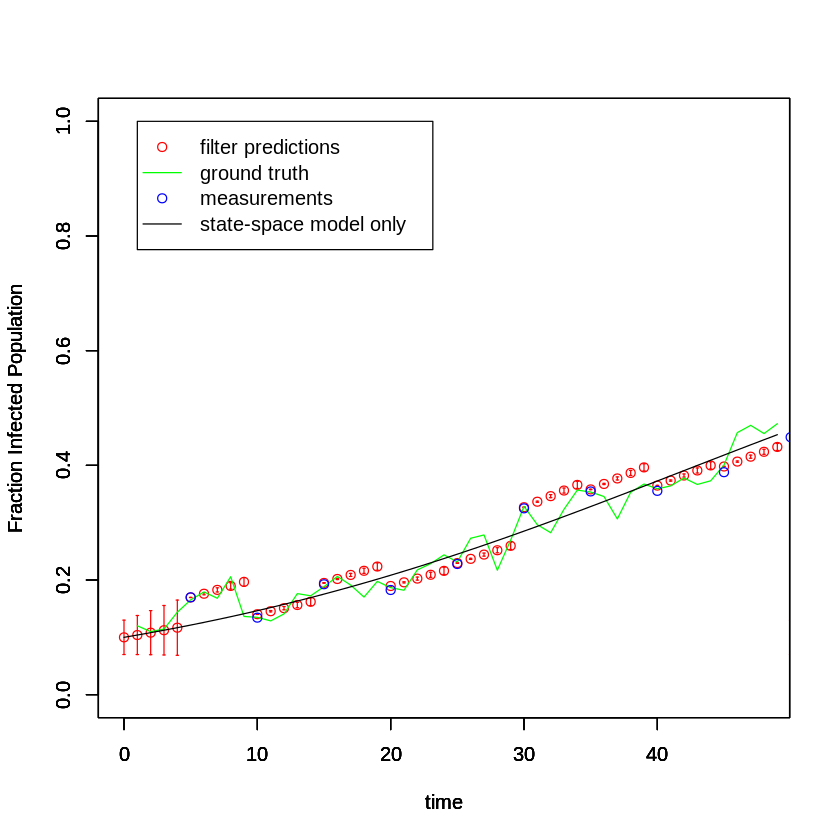

In [ ]:
#@title
m_ind = 1
H = array(c(1,0,0,1), dim=c(2,2))
K = array(dim=c(Nm, 2, 2))
state_no_m = array(dim=c(Np,3))
# intial state
state_no_m[1,] = c(.9,.1,0.0)
for (i in 2:Np)
{
  # estimate state
  state[i,1:2] = Phi(state[i-1, 1:2], beta, gamma, dt)
  state_no_m[i,1:2] = Phi(state_no_m[i-1, 1:2], beta, gamma, dt)
  state_no_m[i,3] = 1 - state_no_m[i,1] - state_no_m[i,2]
  state[i,3] = 1 - state[i,1] - state[i,2]
  # get jacobian and Q
  Jt = J(state[i-1,1:2], beta, gamma, dt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  # estimate covariance
  P[i, 1:2 ,1:2] = Jt%*%P[i-1, 1:2, 1:2]%*%aperm(Jt) + Q
  P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, , ] = P[i, 1:2, 1:2] %*% HT %*% solve(H %*% P[i, 1:2, 1:2] %*% HT + R)
    # state merge
    state[i,1:2] = state[i,1:2] + K[m_ind, ,] %*% (z[m_ind, 1:2] - H %*% state[i,1:2])
    state[i,3] = 1 - state[i,1] - state[i,2]
    # covariance merge
    P[i, 1:2, 1:2] = (I - K[m_ind, , ]%*%H)*P[i, 1:2, 1:2]
    P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }
}

Tplot = 1:50
Mplot = 1:10
xlims = c(0,48)
ylims = c(0, 1)
plot(time[Tplot], state[Tplot,2], col="red", xlim=xlims, ylim=ylims, ylab="Fraction Infected Population", xlab="time")
bottom = state[Tplot, 2] - 3*P[Tplot ,2 ,2]
top = state[Tplot,2] + 3*P[Tplot, 2, 2]
arrows(time, bottom, time, top,length = .01, angle=90,code=3, col="red")
par(new=TRUE)
plot(time[Tplot], g[Tplot,2], xlim=xlims, ylim=ylims, col="green", type='l', ylab="Fraction Infected Population", xlab="time")
par(new=TRUE)
plot(mtime[Mplot], z[Mplot,2], xlim=xlims, ylim=ylims, col = "blue", ylab="Fraction Infected Population", xlab="time")
par(new=TRUE)
plot(time[Tplot], state_no_m[Tplot,2], type="l", xlim=xlims, ylim=ylims, ylab="Fraction Infected Population", xlab="time")
legend(1, 1, legend=c("filter predictions", "ground truth", "measurements", "state-space model only"),
       col=c("red", "green", "blue", "black"), lty= c(NA,1,NA, 1), pch=c(1,NA,1,NA))
error_kalman = 0
error_state_sys = 0

for (i in 2:Np)
{
  error_kalman = error_kalman + ((state[i, ] - g[i, ])%*%(state[i, ] - g[i, ]))[1]
  error_state_sys = error_state_sys + ((state_no_m[i, ] - g[i, ])%*%(state_no_m[i, ] - g[i, ]))[1]
}
cat("filter error: ", error_kalman/dt, "\n")
cat("state-space only error: ", error_state_sys/dt)

As we can see the error calculation of simulations without measurements is better. Varying the number of timesteps, and measurements per sample will effect the difference in errors (for instance trying out 4 measurements over time, gave me results that were better sometimes). But the main problem I believe with the lack of a better error for the filter, is because of our data generation method used samples of $Q$ which again are uncorrelated in time (See data generation section above). That is if we measure an infected population higher than our model simulation predicts we would execept on the next timestep that it will probably still be above our simulation estimate (depedent on the length of timestep). This sort of correlation is not built into our data generation. Our ground truth is produced by perturbing $\hat{x}$ by some uncorrelated amount with mean 0, and therefore our state-space simulation mean should probably do better by just giving us back the mean. I hope that this will not be an issue on real data.

# Parameter Estimation and Prediction on a real Covid Dataset

Finally, we can used the Kalman Filter on real Covid-19 data.

One option for data is to use positive Covid test results as measurements for the infected population. The problem with this is that it is a bias estimator since people who are going to get tested for covid usually suspect they have Covid. Therefore it will probably be an over-estimate of the infected fraction.

As data I used https://covid19-projections.com/ estimates of infected people in Oregon every day of the pandemic till mid march of this year. They estimate the total number of infected people with the following equations:

\begin{gather}
Z^I_i = \text{confirmed-cases}(\frac{1500}{i + 50}(\text{positivity-rate})^.5 + 2
\end{gather}

More information on this estimte is at https://covid19-projections.com/estimating-true-infections-revisited/.
Assuming this is reasonable measurement of the infected population of Oregon, we can now reformulate the filter one more time.

One glaring issue we will need to address is that $\beta$ and potentially $\gamma$ are unknown functions of time as well, otherwise we wouldn't get the multi-modal peaks of infection seen in the data below.



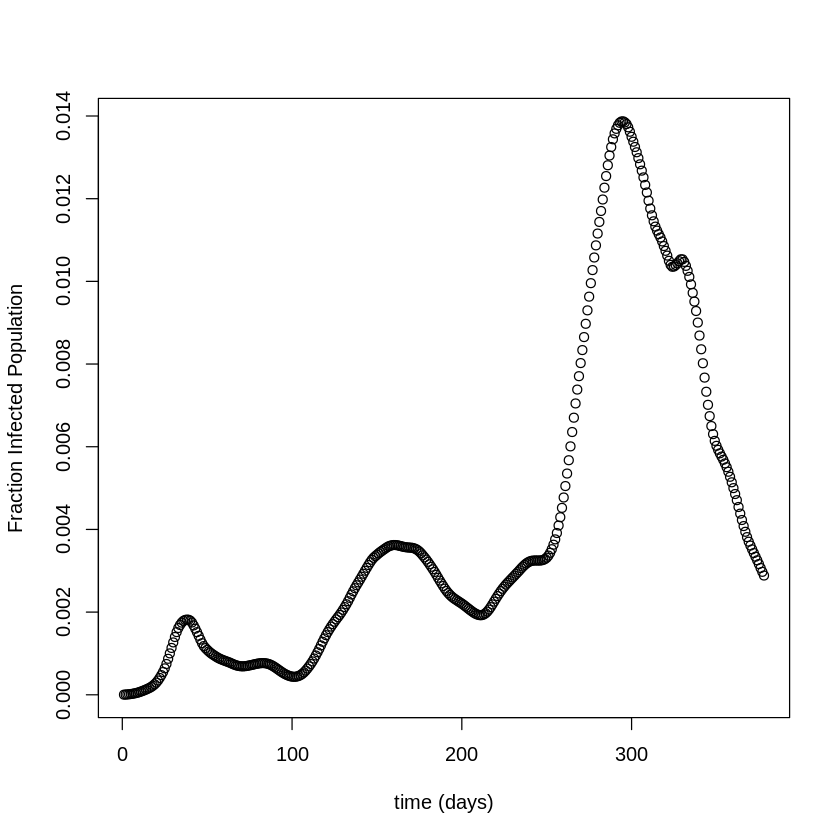

In [ ]:
#@title
 data = read.csv(file = '/content/covid_data2.csv')
# getting oregon data
data = data[order(as.Date(data$date, format="%Y-%m-%d")),]
or_data = data[which(data$state == 'OR'),]
or_data = or_data[1:378,]
# infected population measurements
z = (or_data$perc_current_infected_mean)
# total number of days
T = length(z)
Nm = T
# Number of timesteps between measurements
npm = 4
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (Days)
dt = T/N
# length of measurement step (Days)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)
plot(mtime,z[1:T], xlab="time (days)", ylab="Fraction Infected Population")



There are many ways to estimate $\beta$ and $\gamma$ in real time. One simply way is to add $\beta$ and $\gamma$ as state variables to our equations, but set their state evolution equations to zero, and only update them when we receive a measurement. The filter equations take the same form as before except that now we only have access measurements in $I$, therefore we have that:

\begin{gather}
H = \begin{bmatrix}
0 & 1 & 0\\
\end{bmatrix}
\end{gather}

Obviously this matrix isn't square, but the multiplications work in either case. We also have a static update of $\beta$ and $\gamma$ in $\Phi$ and $J^\Phi$, and need an initial estimate for $\beta$ and $\gamma$ at time 0. To me it seemed sort of subtle how state variables are being updateded in the measurement merging steps, when we aren't even measuring them directly. I'll just derive the measurement update through the kalman gain and mean merging equations, to make more sense of this. The equation for the kalman gain matrix doing the multiplication and inverse out gives:

\begin{gather}
K_j=
\begin{bmatrix}
\frac{Cov(I,S)}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{\sigma^2_{I}}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{Cov(I,\beta)}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{Cov(I,\gamma)}{\sigma^2_I + \sigma^2_{Im}}\\
\end{bmatrix}
\end{gather}

And when we merge the measurement data, and SIR prediction we get:

\begin{gather}
  \hat{X}_{i,j} =
  \begin{bmatrix}
    \hat{S}\\
    \hat{I}\\
    \hat{\beta}\\
    \hat{\gamma}\\
  \end{bmatrix}_{i,j-1}
  +
 \begin{bmatrix}
\frac{Cov(I,S)}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{\sigma^2_{I}}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{Cov(I,\beta)}{\sigma^2_I + \sigma^2_{Im}}\\
\frac{Cov(I,\gamma)}{\sigma^2_I + \sigma^2_{Im}}\\
\end{bmatrix}
(Z_j^I-\hat{I})
\end{gather}

From this equation it seems logical that we will weight the extrapolation about $\gamma$ or $\beta$ from the measurement of $I$ heavier if it's covariance with $I$ is high, but not weight it not as high if either the measurements variance is high or $\hat{I}$ itself has high variance.

### Construction of $R$

I use the same estimate for $Q$ as we did in the previous example. To construct
$R$ I noticed our data set also includes upper and lower bound error estimates, although nowhere could I find if these were 95% confidence intervals, or standard deviations. I construct $R$ assuming these are 95% confidence intervals, and assuming that $2\sigma$ from the mean captures 95% of our uncertainty.

# Results and Analysis


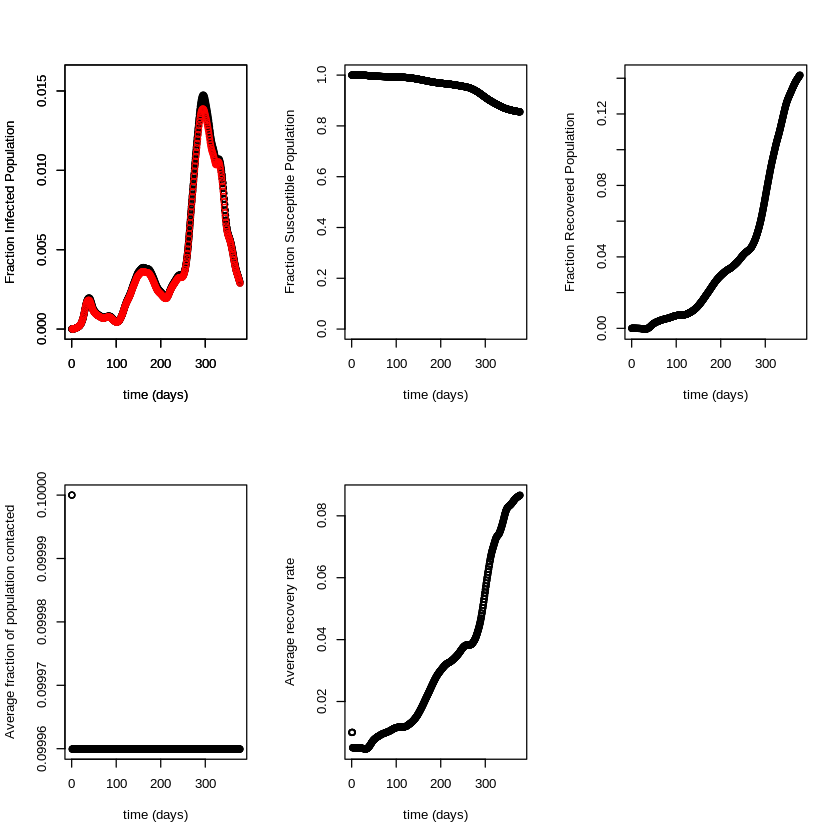

In [ ]:
#@title

options(warn=-1)
R = (or_data$perc_current_infected_upper - or_data$perc_current_infected_lower/4)^2

H = array(c(0,1,0,0), dim=c(1,4))

HT = aperm(H)

K = array(dim=c(Nm,4))

I = array(c(1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1), dim=c(4,4))
# state initialization
state = array(dim=c(Np,5))
state[1,1] = 1 - z[1]
state[1,2] = z[1]
state[1,3] = .1
state[1,4] = .01
state[1,5] = 1 - state[1,1] - state[1,2]


# infected perterbation
I_pert = 1e-12
# perterbation matrix
I_pertM = array(c(0,0,0,0,0,I_pert,0,0,0,0,0,0,0,0,0,0), dim=c(4,4))

# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2],beta*state[1]*state[2] - gamma*state[2], 0, 0))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(- dt * beta * state[2] + 1, dt*beta*state[2], 0, 0,
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1, 0, 0,
                -dt*state[1]*state[2], dt*state[1]*state[2], 1, 0,
                0, -dt*state[2], 0, 1), dim=c(4,4)))
}

# Kalman matrix function
K_fun = function(P, r, i){
  return(c(P[1, 2]/(P[2,2] + r), P[2, 2]/(P[2,2] + r), P[2, 3]/(P[2,2] + r), P[2, 4]/(P[2,2] + r)))
}


# covariance initialization
P = array(dim=c(Np, 5, 5))

for (i in 1:5){
  for (j in 1:5){
    if (i == j){
      if (i == 1 || i == 2 || i == 5){
        P[1,i,i] = .1e-8
      }
      else{
        P[1,i,i] = .05
      }
    }
    else{
      P[1, i, j] = 0.0
    }
  }
}

# filter loop
m_ind = 1
for (i in 2:Np)
{
  beta = state[i-1,3]
  gamma = state[i-1,4]
  # mean propagation without measurements
  state[i,1:4] = Phi(state[i-1, 1:4], beta, gamma, dt)
  state[i,5] = 1 - state[i,1] - state[i,2]
  #print(state[i,])
  # get jacobian and Q
  Jt = J(state[i-1,1:4], beta, gamma, dt)
  #print(Jt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  #print(Q)
  # convariance propagation without measurements
  P[i,1:4,1:4] = Jt%*%P[i-1, 1:4, 1:4]%*%aperm(Jt) + Q
  #P[i, 5, 5] = P[i, 1, 1] + P[i, 2, 2] + 2*P[i, 1, 2]
  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, ] = K_fun(P[i, 1:4, 1:4], R[m_ind])
    # state merge
    state[i,1:4] = state[i,1:4] + K[m_ind, ] * (z[m_ind] - state[i, 2])
    #state[i,5] = 1 - state[i,1] - state[i,2]
    # covariance merge
    P[i, 1:4, 1:4] = (I - K[m_ind, ]%*%H)*P[i, 1:4, 1:4]
    P[i, 5, 5] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }
}
#plot(mtime, K[, 3], xlim=c(0,Nm))
par(mfrow=c(2,3))
plot(time, state[, 2], xlim=c(0,T),ylim=c(0,.016), xlab="time (days)", ylab="Fraction Infected Population")
par(new=TRUE)
plot(mtime, z, xlim=c(0,T), ylim = c(0,.016), col="red", xlab="time (days)", ylab="Fraction Infected Population")
plot(time, state[, 1], xlim=c(0,T),ylim=c(0,1), xlab="time (days)", ylab="Fraction Susceptible Population")
plot(time, state[, 5], xlab="time (days)", ylab="Fraction Recovered Population")
plot(time, state[,3], xlab="time (days)", ylab="Average fraction of population contacted")
plot(time, state[,4], xlab="time (days)", ylab="Average recovery rate")

This is an interesting result.  In the above we have a measurement for every day, and extrapolate with our state equation for 4 steps inbetween days. These pretty closely fit the red curve of the fraction of infected measurements, but what is interesting is that our model has "explained" the multimodality of the infected fraction purely through holding contact rate constant, and varying recovery rate in time. This is counter intuative to what I would have expected, and probably no what is actually occuring in reality. If did believe that this model was accurate in $\beta$ and $\gamma$, I should probably reject that social distancing has any affect on stopping the virus because $\beta$ remained constant the whole time, and Oregon went through multiple lock downs.

 What this result might be pointing to (in a very handway way) is the same solution curves of the SIR model can be produced from more than one set of differential equations, where $\beta(t)$ and $\gamma(t)$ are different. To be clear this is not a statement about the uniqueness of a solution to a single SIR model with a fixed $\beta(t)$ and $\gamma(t)$ function, which I am not commenting on.

 In order to produce a more realistic model, I removed any estimation of $\gamma$ from the model altogether, and set it to $\frac{1}{14}$ after a quick google search revealed that almost every single website said that most people recover after 2 weeks. My hope was that this would force $\beta$ to be a function of time.



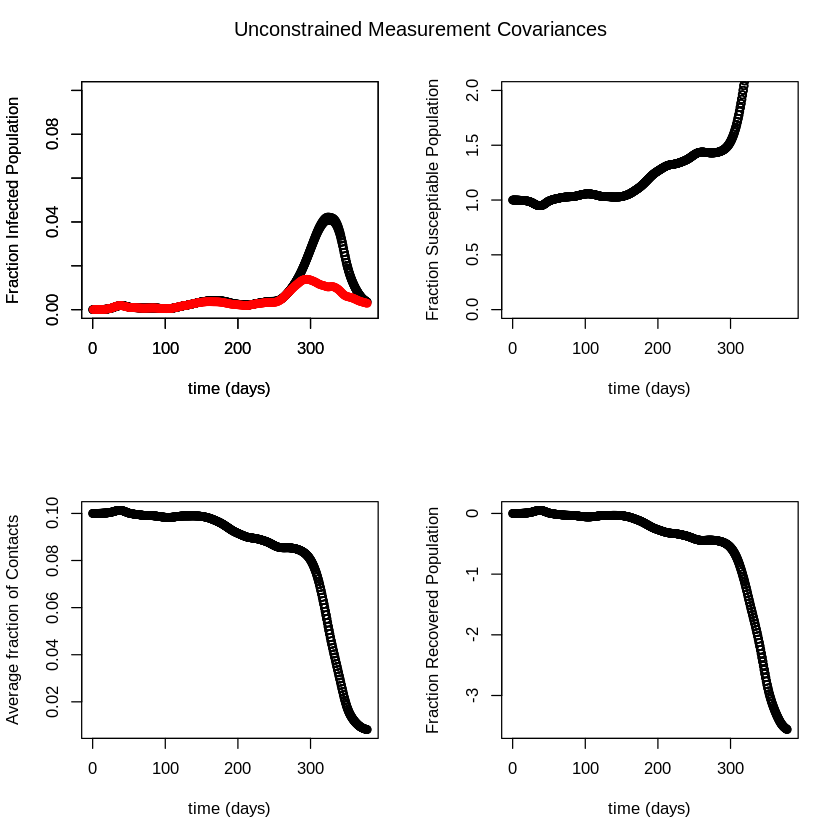

In [ ]:
#@title

R = ((or_data$perc_current_infected_upper - or_data$perc_current_infected_lower/4)^2)/1000
H = array(c(0,1,0), dim=c(1,3))
HT = aperm(H)
K = array(dim=c(Nm,3))
I = array(c(1,0,0,0,1,0,0,0,1), dim=c(3,3))
# state initialization
state = array(dim=c(Np,4))
state[1,1] = 1 - z[1]
state[1,2] = z[1]
state[1,3] = .1
state[1,4] = 1 - state[1,1] - state[1,2]

gamma = 1/14

# infected perterbation
I_pert = 1e-6
# perterbation matrix
I_pertM = array(c(0,0,0,0,I_pert,0,0,0,0), dim=c(3,3))

# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2],beta*state[1]*state[2] - gamma*state[2], 0))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(-dt * beta * state[2] + 1, dt*beta*state[2], 0
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1, 0
                -dt*state[1]*state[2], dt*state[1]*state[2], 1), dim=c(3,3)))
}

# Kalman matrix function
K_fun = function(P, r, i){
  return(c(P[1, 2]/(P[2,2] + r), P[2, 2]/(P[2,2] + r), P[2, 3]/(P[2,2] + r)))
}


# covariance initialization
P = array(dim=c(Np, 4, 4))

for (i in 1:4){
  for (j in 1:4){
    if (i == j){
      if (i == 1 || i == 2 || i == 4){
        P[1,i,i] = .1e-8
      }
      else{
        P[1,i,i] = .05
      }
    }
    else{
      P[1, i, j] = 0.0
    }
  }
}

# filter loop
m_ind = 1
for (i in 2:Np)
{

  beta = state[i-1,3]

  # mean propagation without measurements
  state[i,1:3] = Phi(state[i-1, 1:3], beta, gamma, dt)
  state[i,4] = 1 - state[i,1] - state[i,2]
  #print(state[i,])

  # get jacobian and Q
  Jt = J(state[i-1,1:3], beta, gamma, dt)
  #print(Jt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  #print(Q)
  # convariance propagation without measurements
  P[i, 1:3, 1:3] = Jt%*%P[i-1, 1:3, 1:3]%*%aperm(Jt) + Q
  P[i, 4, 4] = P[i, 1, 1] + P[i, 2, 2] + 2*P[i, 1, 2]

  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, ] = K_fun(P[i, 1:3, 1:3], R[m_ind])
    # state merge
    state[i,1:3] = state[i, 1:3] + K[m_ind, ] * (z[m_ind] - state[i, 2])
    state[i,4] = 1 - state[i,1] - state[i,2]
    # covariance merge
    P[i, 1:3, 1:3] = (I - K[m_ind, ]%*%H)*P[i, 1:3, 1:3]
    P[i, 4, 4] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }

}

par(mfrow=c(2,2))
plot(time, state[, 2], xlim=c(0,T),ylim=c(0,.1), xlab="time (days)", ylab="Fraction Infected Population")
par(new=TRUE)
plot(mtime, z, xlim=c(0,T), ylim = c(0,.1), col="red", xlab="time (days)", ylab="Fraction Infected Population")
plot(time, state[, 1], xlim=c(0,T),ylim=c(0,2), xlab="time (days)", ylab="Fraction Susceptiable Population")
plot(time, state[,3], xlab="time (days)", ylab="Average fraction of Contacts")
plot(time, state[,4], xlab="time (days)", ylab="Fraction Recovered Population")
mtext("Unconstrained Measurement Covariances", side = 3, line = -2, outer = TRUE)

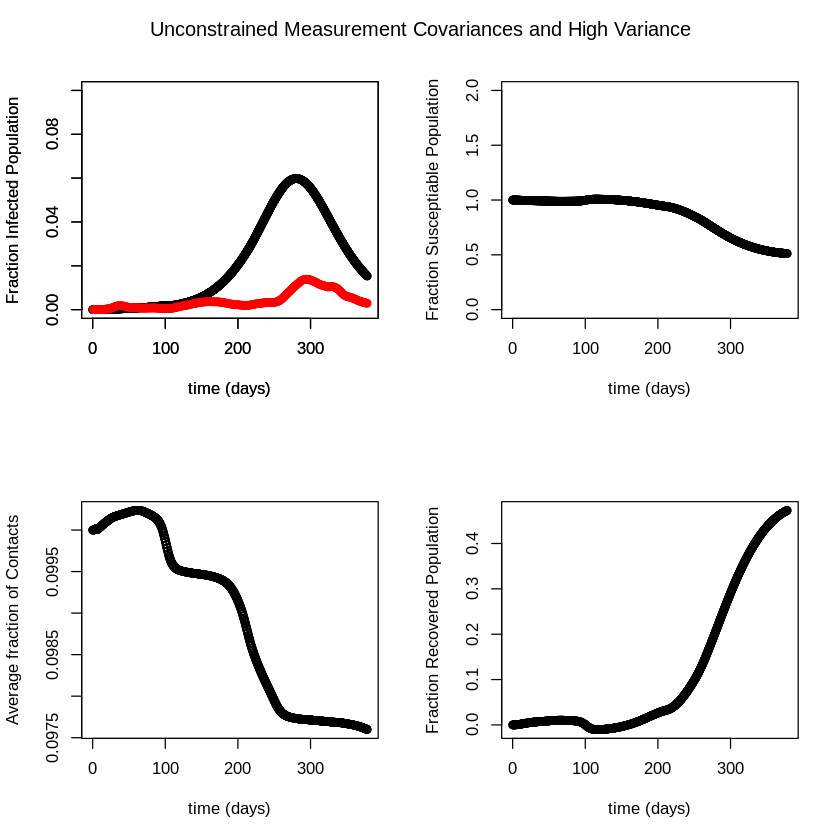

In [ ]:
#@title

R = ((or_data$perc_current_infected_upper - or_data$perc_current_infected_lower/4)^2)
H = array(c(0,1,0), dim=c(1,3))
HT = aperm(H)
K = array(dim=c(Nm,3))
I = array(c(1,0,0,0,1,0,0,0,1), dim=c(3,3))
# state initialization
state = array(dim=c(Np,4))
state[1,1] = 1 - z[1]
state[1,2] = z[1]
state[1,3] = .1
state[1,4] = 1 - state[1,1] - state[1,2]

gamma = 1/14

# infected perterbation
I_pert = 1e-6
# perterbation matrix
I_pertM = array(c(0,0,0,0,I_pert,0,0,0,0), dim=c(3,3))

# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2],beta*state[1]*state[2] - gamma*state[2], 0))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(-dt * beta * state[2] + 1, dt*beta*state[2], 0
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1, 0
                -dt*state[1]*state[2], dt*state[1]*state[2], 1), dim=c(3,3)))
}

# Kalman matrix function
K_fun = function(P, r, i){
  return(c(P[1, 2]/(P[2,2] + r), P[2, 2]/(P[2,2] + r), P[2, 3]/(P[2,2] + r)))
}


# covariance initialization
P = array(dim=c(Np, 4, 4))

for (i in 1:4){
  for (j in 1:4){
    if (i == j){
      if (i == 1 || i == 2 || i == 4){
        P[1,i,i] = .1e-8
      }
      else{
        P[1,i,i] = .05
      }
    }
    else{
      P[1, i, j] = 0.0
    }
  }
}

# filter loop
m_ind = 1
for (i in 2:Np)
{

  beta = state[i-1,3]

  # mean propagation without measurements
  state[i,1:3] = Phi(state[i-1, 1:3], beta, gamma, dt)
  state[i,4] = 1 - state[i,1] - state[i,2]
  #print(state[i,])

  # get jacobian and Q
  Jt = J(state[i-1,1:3], beta, gamma, dt)
  #print(Jt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  #print(Q)
  # convariance propagation without measurements
  P[i, 1:3, 1:3] = Jt%*%P[i-1, 1:3, 1:3]%*%aperm(Jt) + Q
  P[i, 4, 4] = P[i, 1, 1] + P[i, 2, 2] + 2*P[i, 1, 2]

  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, ] = K_fun(P[i, 1:3, 1:3], R[m_ind])
    # state merge
    state[i,1:3] = state[i, 1:3] + K[m_ind, ] * (z[m_ind] - state[i, 2])
    state[i,4] = 1 - state[i,1] - state[i,2]
    # covariance merge
    P[i, 1:3, 1:3] = (I - K[m_ind, ]%*%H)*P[i, 1:3, 1:3]
    P[i, 4, 4] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }

}

par(mfrow=c(2,2))
plot(time, state[, 2], xlim=c(0,T),ylim=c(0,.1), xlab="time (days)", ylab="Fraction Infected Population")
par(new=TRUE)
plot(mtime, z, xlim=c(0,T), ylim = c(0,.1), col="red", xlab="time (days)", ylab="Fraction Infected Population")
plot(time, state[, 1], xlim=c(0,T),ylim=c(0,2), xlab="time (days)", ylab="Fraction Susceptiable Population")
plot(time, state[,3], xlab="time (days)", ylab="Average fraction of Contacts")
plot(time, state[,4], xlab="time (days)", ylab="Fraction Recovered Population")
mtext("Unconstrained Measurement Covariances and High Variance", side = 3, line = -2, outer = TRUE)

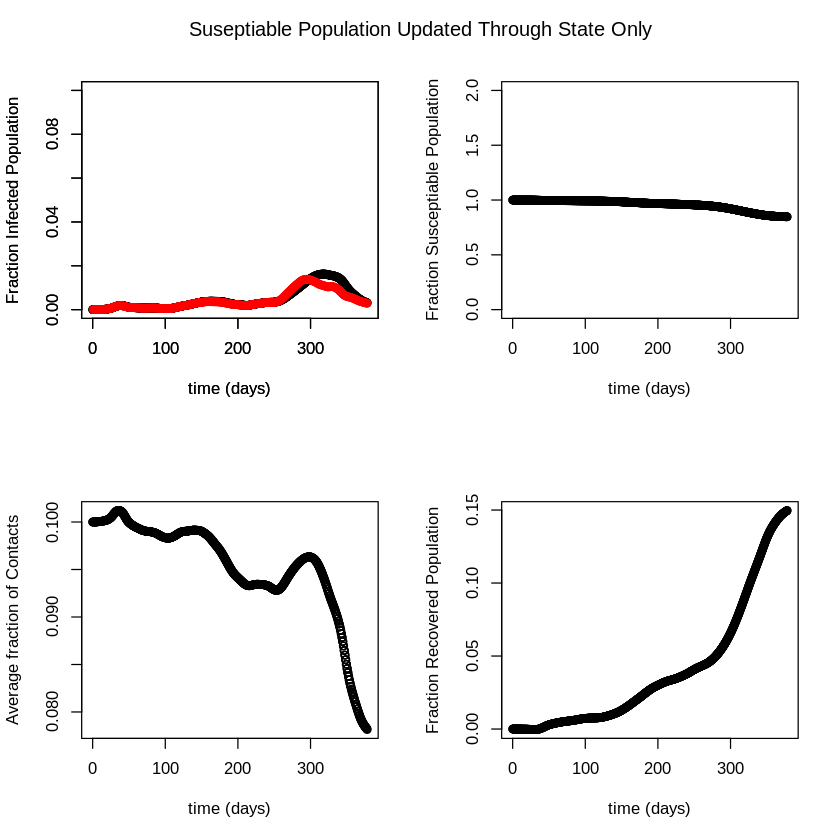

In [ ]:
#@title

options(warn=-1)
R = ((or_data$perc_current_infected_upper - or_data$perc_current_infected_lower/4)^2)/1000

H = array(c(0,1,0), dim=c(1,3))

HT = aperm(H)

K = array(dim=c(Nm,3))
K_1 = array(dim=c(Nm,3))

I = array(c(1,0,0,0,1,0,0,0,1), dim=c(3,3))
# state initialization
state = array(dim=c(Np,4))
state[1,1] = 1 - z[1]
state[1,2] = z[1]
state[1,3] = .1
state[1,4] = 0.0


gamma = 1/14
# infected perterbation
I_pert = 1e-6
# perterbation matrix
I_pertM = array(c(0,0,0,0,I_pert,0,0,0,0), dim=c(3,3))

# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2], beta*state[1]*state[2] - gamma*state[2], 0))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(-dt * beta * state[2] + 1, dt*beta*state[2], 0
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1, 0
                -dt*state[1]*state[2], dt * state[1] * state[2], 1), dim=c(3,3)))
}

# Kalman matrix function
K_fun = function(P, r, i){
  return(c(0, P[2, 2]/(P[2,2] + r), P[2, 3]/(P[2,2] + r)))
}
# Kalman matrix function
K_fun_1 = function(P, r, i){
  return(c(P[1, 2]/(P[2,2] + r), P[2, 2]/(P[2,2] + r), P[2, 3]/(P[2,2] + r)))
}

#c(P[1, 2]/(P[2,2] + r)

# covariance initialization
P = array(dim=c(Np, 4, 4))


for (i in 1:4){
  for (j in 1:4){
    if (i == j){
      if (i == 1 || i == 2 || i == 4){
        P[1,i,i] = .1e-6
      }
      else{
        P[1,i,i] = .0001
      }
    }
    else{
      P[1, i, j] = 0.0
    }
  }
}


# filter loop
m_ind = 1
for (i in 2:Np)
{

  beta = state[i-1,3]
  # mean propagation without measurements
  state[i,1:3] = Phi(state[i-1, 1:3], beta, gamma, dt)
  state[i,4] = 1 - state[i,1] - state[i,2]

  # get jacobian and Q
  Jt = J(state[i-1,1:3], beta, gamma, dt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  # convariance propagation without measurements
  P[i, 1:3, 1:3] = Jt%*%P[i-1, 1:3, 1:3]%*%aperm(Jt) + Q
  P[i, 4, 4] = P[i, 1, 1] + P[i, 2, 2] + 2*P[i, 1, 2]


  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, ] = K_fun(P[i, 1:3, 1:3], R[m_ind])

    #print(K[m_ind,])
    # state merge
    state[i,1:3] = state[i, 1:3] + K[m_ind, ] * (z[m_ind] - state[i, 2])
    state[i,4] = 1 - state[i,1] - state[i,2]

    # covariance merge
    P[i, 1:3, 1:3] = (I - (K[m_ind, ]%*%H))*P[i, 1:3, 1:3]
    P[i, 4, 4] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }
}


par(mfrow=c(2,2))
plot(time, state[, 2], xlim=c(0,T),ylim=c(0,.1), xlab="time (days)", ylab="Fraction Infected Population")
par(new=TRUE)
plot(mtime, z, xlim=c(0,T), ylim = c(0,.1), col="red", xlab="time (days)", ylab="Fraction Infected Population")
plot(time, state[, 1], xlim=c(0,T),ylim=c(0,2), xlab="time (days)", ylab="Fraction Susceptiable Population")
plot(time, state[,3], xlab="time (days)", ylab="Average fraction of Contacts")
plot(time, state[,4], xlab="time (days)", ylab="Fraction Recovered Population")
mtext("Suseptiable Population Updated Through State Only", side = 3, line = -2, outer = TRUE)

#length(time)
#length(z)
#arrows(time[c(TRUE,FALSE)], bottom[c(TRUE,FALSE)], time[c(TRUE,FALSE)], top[c(TRUE,FALSE)],length = .01, angle=90,code=3, col="red")

Upon removing $\gamma$ from the update equations I found the filter incorrectly predicted that the suspetiable population raises way above 1, which doesn't make any physical sense (see the first panel). There is a simple explination for this. The the SIR model necessarly "conserves population" since (assuming we have inital conditions that sum to 1):

\begin{gather}
  \frac{\partial S}{\partial t} + \frac{\partial I}{\partial t} + \frac{\partial R}{\partial t} = - \beta IS + \beta IS - \gamma I + \beta IS - \beta IS + \gamma I = 0
\end{gather}

While this is true of the state space model, no where is it inforced in the filter where measurements are merged. One solution to this problem is to specify a covariance between the measured infected fraction and the state-space predicted suseptiable. In the kalman filter framework I have been using I don't know how to do this, and I think there could be interesting work done here.

Another possible solution is to drastically increase the variance of the measurements (the second panel) in the hope that it will allow the state-space model "enforce" the conservation of population. I does do this, but now since $\beta$ is so rapidly changing, when we 4 timesteps between measurements with the same $\beta$ we over estimate the infected population. This points to the important result that having lots of accurate measurments is very important when $\beta$ is changing fast in time. Secondly, this strategy is bad because we know that the measurement variance is much smaller.

An alternative is to instead remove any explicit effect measured infected fraction has on the estimated suseptiable fraction (the measurements still do effect the suseptiable fraction, but now only through the later state updates) by taking the first entry of the kalman gain matrix to be 0. I fully admit it is unclear if this is a poor modeling technique or not.

The third panel of figures displays this reformulation. The population fractions all appear completely reasonable to me. It is interesting to consider the average fraction of contacts curve. It for the most part decreases throughout the pandemic. I think this could be a resonable approximation, although I also believe that now the curve is "too constrained", i.e. the movement between population bins must be completely explained by the the variation of $\beta$ over time, which is not true. Things like vaccination definitely are leading to a decrease in infected population recently and the only way the infected population will decrease in this model is if there is no one else in the suspetiable population to infect or if $\beta$ plumets. We see that our model is a least picking up on the fact that not everyone has been infected and chooses the later choice. In summary this is a limitation of the underlying state-space model.


# Impact

The impact of this work is threefold:

- It it appears that the kalman filter paired with a state-space model (one that is better than SIR probably) may have predictive powers in estimating the current state of covid in time. This could lead to considering policy decisions based on a model like this, such as going into lockdown versus opening back up. If I were given the model I just created I would not base my policy decisions on it, because I would want more verification that it was a good model.

- It appears through the sensitivity to measurement variance seen between panels 1 and 2 of the above, that acccuracy of measurements is highly important for estimating parameters in kalman filter based covid models. This would could potential lead to researchers wanting to fund more efforts in testing of covid, especially when there is a radical change in the infected population.

- A model like this may mis inform people that we should be constantly in lock down no matter what, because (assuming the entire population doesn't become infected and recovered) the only parameter able lower the number of infected people is the average contacts per day. This is a flaw in the underlaying SIR model, and not a reality about how we can stop covid.

# Conclusions

Much of this work was attempting to understand the theoretical basis of the kalman filter, and figure out how to apply it to non-linear systems. Upon application to the SIR model pieces of the model were satifsying, but many issues still remain.

Here is a list of things that could be investigated to make this model better:

- A better state-space model, with potential vacination and seasonal effects.
- An specfic anaylsis of non-linear covariance propgation in the context of that model so we don't need to use a jacobian.
- The specification of a covariance between a measured state, and a different estimated state in order to enforce, in our case, a conservation property. Where as currently covariances are only between estimated states and other estimated state or measured states and other measured states.


# References

[1] Corporation, T. A. S., & Gelb, A. (1974). Applied Optimal Estimation. The MIT Press.

[2] Alex Becker. (2018). Online Kalman Filter Tutorial. KalmanFilter.Net. https://www.kalmanfilter.net/default.aspx

[3] Pei, Y., Biswas, S., Fussell, D. S., & Pingali, K. (2019). An elementary introduction to Kalman filtering. Communications of the ACM, 62(11), 122–133. https://doi.org/10.1145/3363294